In [1]:
options(repr.plot.width  = 15, repr.plot.height = 10)

In [39]:
library(AmesHousing)

# Helper packages
library(dplyr)     # for data manipulation
library(ggplot2)   # for awesome graphics
require(gridExtra) # for make subplot 
library(ggpubr)    # for make subplot and more
library(vip)

# Modeling process packages
library(caret)     # for resampling and model training
library(recipes)  # for feature engineering tasks

In [3]:
# Informacion general del modelo generado por Caret
knnModelInfo <- getModelInfo(model = "knn", regex = FALSE)[[1]]
knnModelInfo

parameter,class,label
<chr>,<chr>,<chr>
k,numeric,#Neighbors


# Regression

In [4]:
ames <- AmesHousing::make_ames()

In [5]:
index_caret <- createDataPartition(ames$Sale_Price, p = 0.7, 
                               list = FALSE, )
house_train <- ames[index_caret, ]
house_test  <- ames[-index_caret, ]

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


## Distance measures

$$Euclidian\ dist(x_a, x_b) = \sqrt{ \sum_j^k(x_{aj}−x_{bj})^2}$$
$$Manhattan\ dist(x_a, x_b) = \sum_j^k|x_{aj}−x_{bj}|$$


In [6]:
two_houses <- house_train[1:2, c("Gr_Liv_Area", "Year_Built")]
two_houses

Gr_Liv_Area,Year_Built
<int>,<int>
896,1961
1329,1958


In [7]:
# Euclidean
dist(two_houses, method = "euclidean")

         1
2 433.0104

In [8]:
# Manhattan
dist(two_houses, method = "manhattan")

    1
2 436

Debido a que la distancia de Euclides usa el cuadrado de las distancias es mas sensible a outliers. Por esto es importante normalizar la las variables antes de hacer los calculos. Esto debido a que variables con escalas mas grandes tienen mas peso sobre el resultado final que las de escala mas pequeña.

In [9]:
house1 <- data.frame(rooms = c(2,3,1), year = c(2020, 2020, 2010))
house1

rooms,year
<dbl>,<dbl>
2,2020
3,2020
1,2010


In [10]:
dist(house1)

         1        2
2  1.00000         
3 10.04988 10.19804

In [11]:
house1_sd <- house1 %>% 
    mutate(rooms=(rooms - mean(rooms))/sd(rooms),
           year=(year - mean(year))/sd(year))
house1_sd

rooms,year
<dbl>,<dbl>
0,0.5773503
1,0.5773503
-1,-1.1547005


In [12]:
dist(house1_sd)

         1        2
2 1.000000         
3 2.000000 2.645751

## Modeling

In [13]:
# Seleccionamos la version de resampling para el modelo
cv <- trainControl(
  method = "cv", 
  number = 10,
)

# Creamos un vector de valores para probar con el parametro k de modelo
hyper_grid <- data.frame(k = c(10, 20))

knn_fit <- train(
  Sale_Price ~ ., 
  data = house_train, 
  method = "knn", 
  trControl = cv, 
  tuneGrid = hyper_grid,
  metric = "RMSE",
)
knn_fit

k-Nearest Neighbors 

2053 samples
  80 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1848, 1848, 1846, 1847, 1848, 1848, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE     
  10  44180.21  0.6983367  28970.92
  20  45399.94  0.6971540  29639.03

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 10.

In [14]:
# knnreg es el modelo que esta corriendo por atras en caret
class(knn_fit$finalModel)

[1] "knnreg"

### Scatter plot de la prediccion vs el valor real en test

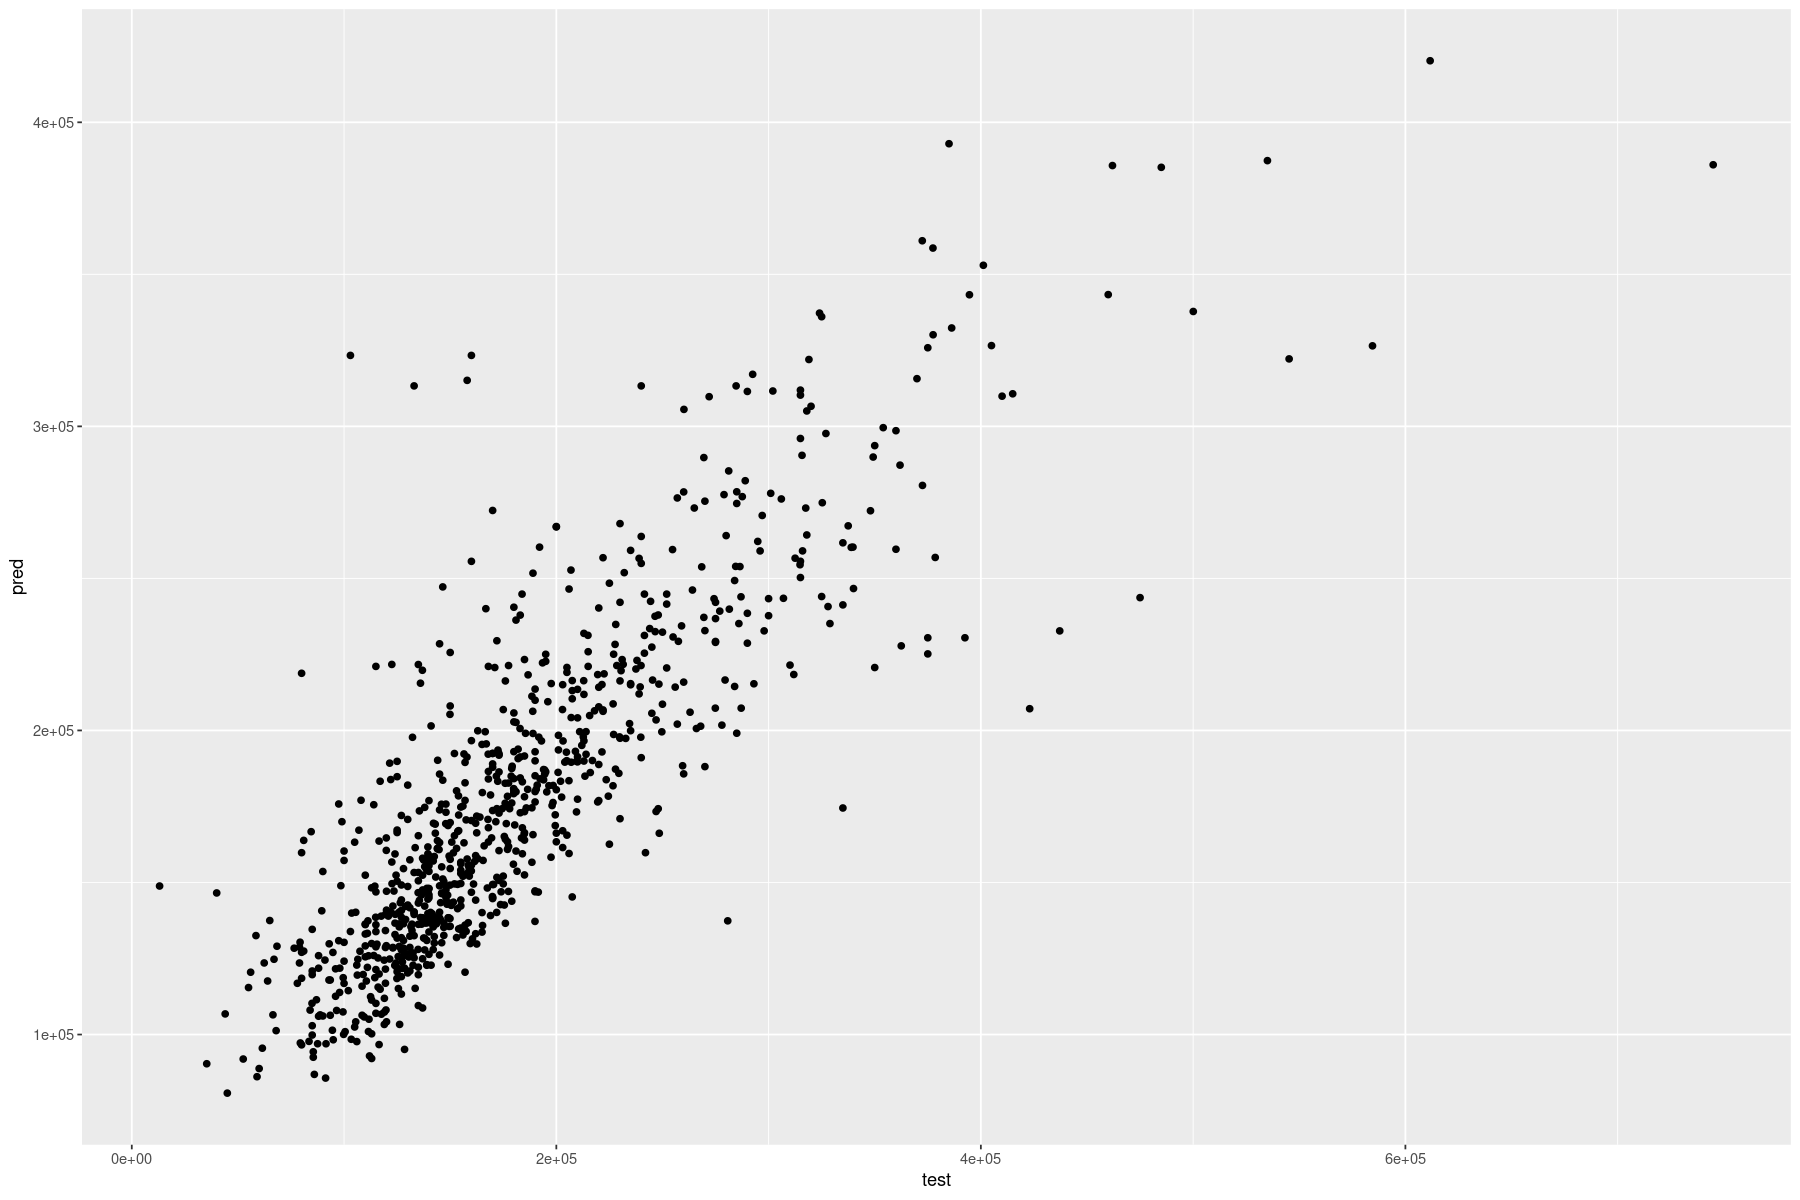

In [15]:
data.frame(pred = predict(knn_fit, house_test), test = house_test$Sale_Price ) %>% 
    ggplot(aes(x=test, y=pred)) + geom_point()

## Choosing k
El perfomance de KNN es muy sensible a la eleccion de k, donde valores valos tienden a hacer overfitting mientrs valores muy grandes tienden a hacer underfitting.

## Feature engineering
Hay una libreria que permite crear un pipeline con todas las transformaciones que queremos hacer a la data para que entre a nuestro modelo y que nos facilita el proceso para evaluar luego en la fase de testing donde simplemente pasamos la data son tener que procesarlar porque ya esta todo en el pipeline. Esto es tremendamente util para los modelos que necesitan que las variables estan por ejemplo en la misma escala.


<img src="https://www.clipartkey.com/mpngs/m/191-1919605_recipes-r-package-logo.png" width=200>

[Recipe doc](https://recipes.tidymodels.org/articles/Simple_Example.html)




* `step_dummy()`: creating dummy variables from categorical variables.
* `step_integer()`: creating dummy variables from categorical variables.
* `step_zzzimpute()`: where instead of “zzz” it is the name of a method, such as step_knnimpute(), step_meanimpute(), step_modeimpute(). I find that the fancier imputation methods are reeeeally slow for decently large datasets, so I would probably do this step outside of the recipes package unless you just want to do a quick mean or mode impute (which, to be honest, I often do).
* `step_scale()`: normalize to have a standard deviation of 1.
* `step_center()`: center to have a mean of 0.
* `step_nzv()`: remove variables that have (or almost have) the same value for every data point.


In each step, you need to specify which variables you want to apply it to. There are many ways to do this:

* Specifying the variable name(s) as the first argument
* Standard dplyr selectors:
    * `everything()` applies the step to all columns,
    * `contains()` allows you to specify column names that contain a specific string,
    * `starts_with()` allows you to specify column names that start with a sepcific string,
    * etc
* Functions that specify the role of the variables:
    * `all_predictors()` applies the step to the predictor variables only
    * `all_outcomes()` applies the step to the outcome variable(s) only
* Functions that specify the type of the variables:
    * `all_nominal()` applies the step to all variables that are nominal (categorical)
    * `all_numeric()` applies the step to all variables that are numeric

In [16]:
# log transformation
blueprint_house <- recipe(Sale_Price ~ ., data = house_train) %>%
  step_nzv(all_nominal()) %>%
  step_integer(matches("Qual|Cond|QC|Qu")) %>%
  step_center(all_numeric(), -all_outcomes()) %>%
  step_scale(all_numeric(), -all_outcomes()) %>%
  step_dummy(all_nominal(), -all_outcomes(), one_hot = TRUE)

In [17]:
blueprint_house

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Sparse, unbalanced variable filter on all_nominal()
Integer encoding for matches("Qual|Cond|QC|Qu")
Centering for all_numeric(), -all_outcomes()
Scaling for all_numeric(), -all_outcomes()
Dummy variables from all_nominal(), -all_outcomes()

In [18]:
prepare <- prep(blueprint_house, training = house_train)
prepare

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Training data contained 2053 data points and no missing data.

Operations:

Sparse, unbalanced variable filter removed Street, Alley, Land_Contour, ... [trained]
Integer encoding for Condition_1, Overall_Qual, Overall_Cond, ... [trained]
Centering for Lot_Frontage, Lot_Area, ... [trained]
Scaling for Lot_Frontage, Lot_Area, ... [trained]
Dummy variables from MS_SubClass, MS_Zoning, Lot_Shape, ... [trained]

In [19]:
baked_train <- bake(prepare, new_data = house_train)
baked_test <- bake(prepare, new_data = house_test)
head(baked_train)

Lot_Frontage,Lot_Area,Condition_1,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Exter_Qual,Exter_Cond,⋯,Sale_Type_COD,Sale_Type_Con,Sale_Type_ConLD,Sale_Type_ConLI,Sale_Type_ConLw,Sale_Type_CWD,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.6619589,0.20483261,-1.20426482,-0.78425416,0.3851472,-0.3249560,-1.1021611,-0.57598220,0.6689207,0.376164,⋯,0,0,0,0,0,0,0,0,0,1
0.6920639,0.56245962,-0.04679493,-0.07309083,0.3851472,-0.4234648,-1.2450979,0.03055904,0.6689207,0.376164,⋯,0,0,0,0,0,0,0,0,0,1
0.4813287,0.50337341,-0.04679493,-0.78425416,-0.5216271,0.8571499,0.6607258,-0.57598220,0.6689207,0.376164,⋯,0,0,0,0,0,0,0,0,0,1
0.6017488,-0.01745048,-0.04679493,-0.07309083,0.3851472,0.8899862,0.6607258,-0.46365975,0.6689207,0.376164,⋯,0,0,0,0,0,0,0,0,0,1
-0.5121376,-0.70133607,-0.04679493,1.34923585,-0.5216271,0.9884950,0.8036625,-0.57598220,-0.7483076,0.376164,⋯,0,0,0,0,0,0,0,0,0,1
-0.5723477,-0.63792319,-0.04679493,1.34923585,-0.5216271,0.7914774,0.5654346,-0.57598220,-0.7483076,0.376164,⋯,0,0,0,0,0,0,0,0,0,1


### Modeling usando el preprocesado

In [20]:
# Specify resampling strategy
cv <- trainControl(
  method = "cv", 
  number = 10, 
)

# Create grid of hyperparameter values
hyper_grid <- expand.grid(k = seq(10, 50, by = 10))

# Tune a knn model using grid search
knn_fit <- train(
  blueprint_house, 
  data = house_train, 
  method = "knn", 
  trControl = cv, 
  tuneGrid = hyper_grid,
  metric = "RMSE"
)
knn_fit

k-Nearest Neighbors 

2053 samples
  80 predictor

Recipe steps: nzv, integer, center, scale, dummy 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1849, 1846, 1847, 1847, 1847, 1848, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE     
  10  31676.16  0.8577376  20092.03
  20  32517.09  0.8555631  20687.12
  30  33200.98  0.8536166  21270.99
  40  33871.54  0.8529802  21818.27
  50  34568.95  0.8503892  22269.69

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 10.

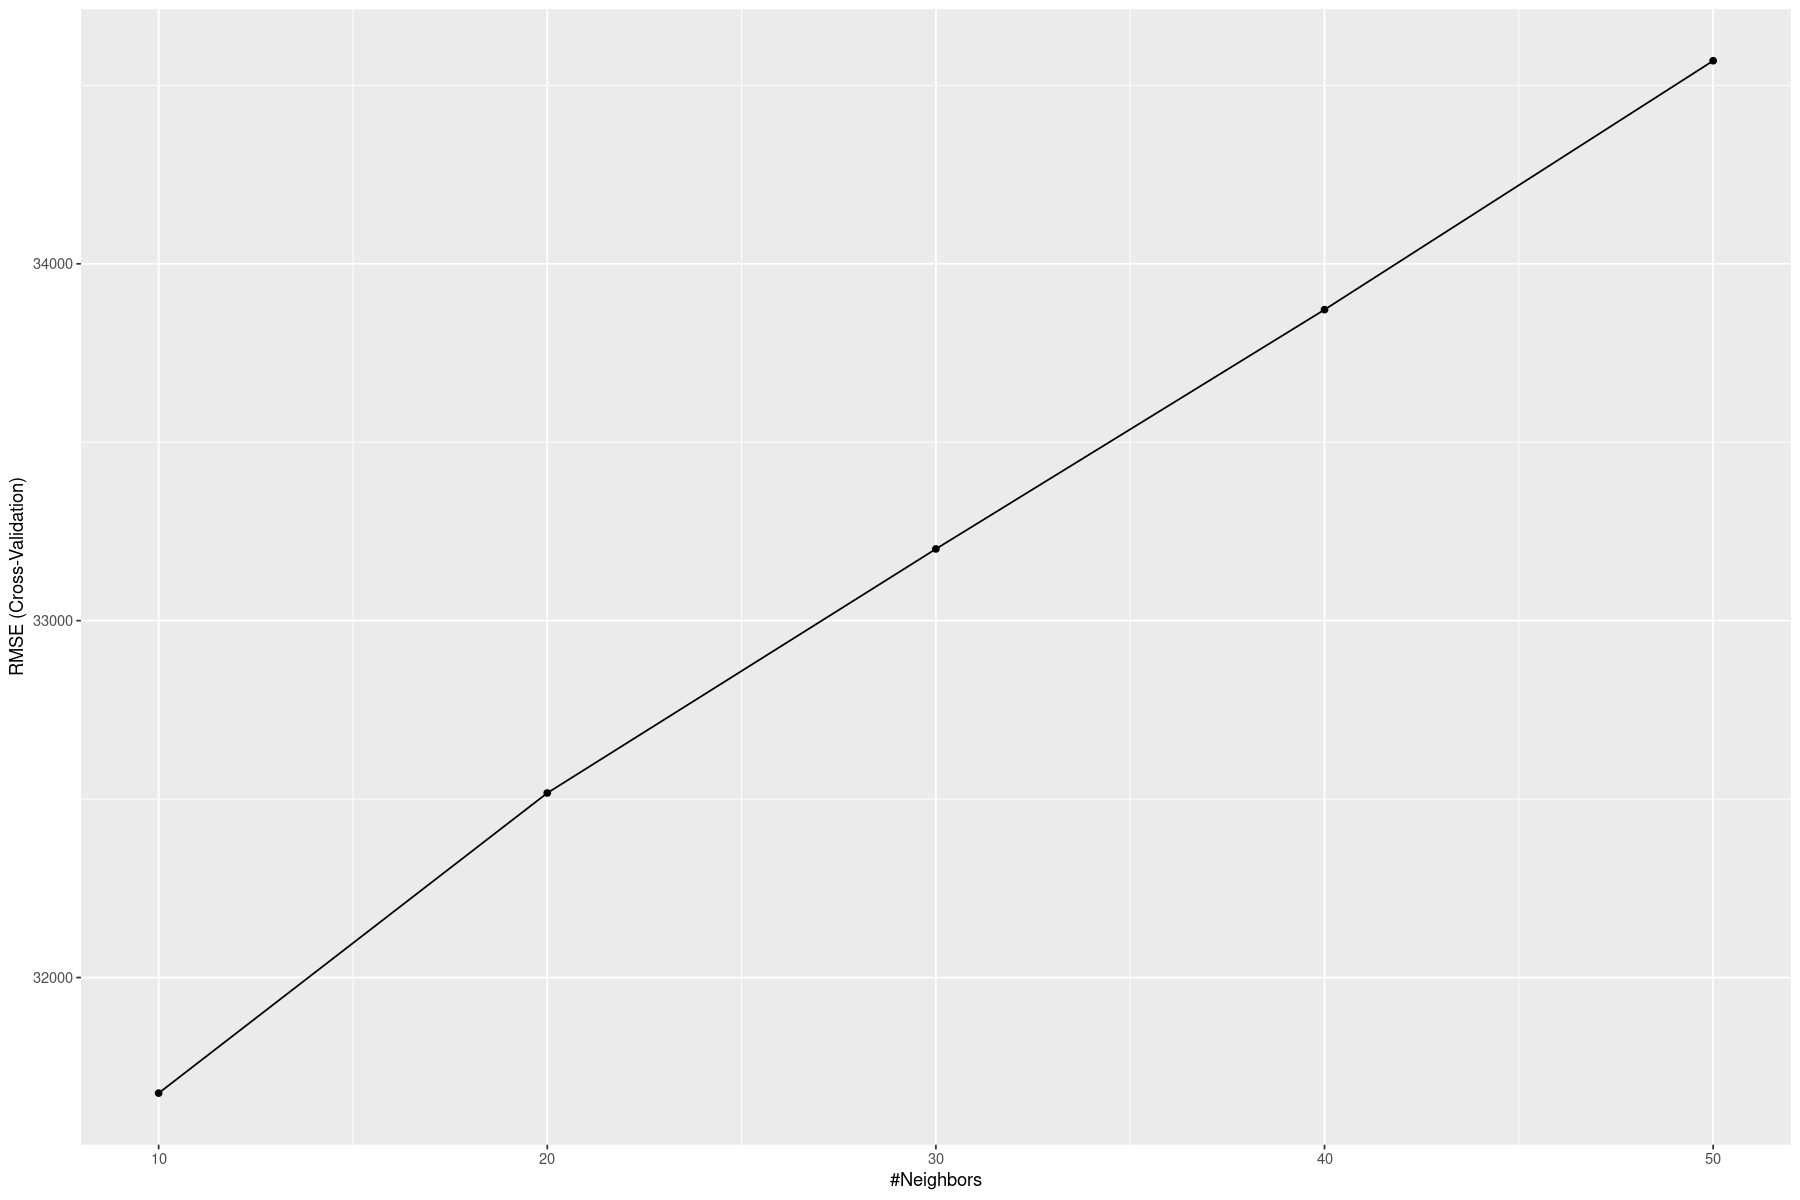

In [21]:
ggplot(knn_fit)


# Classification

##  Load data

In [22]:
data("attrition", package = "modeldata")
# Job attrition data
attrition <- attrition %>% 
  mutate_if(is.ordered, .funs = factor, ordered = FALSE)

## Spliting

In [23]:
index_caret <- createDataPartition(attrition$Attrition, p = 0.7, list = FALSE)
attrition_train <- attrition[index_caret, ]
attrition_test  <- attrition[-index_caret, ]

## Modeling

In [36]:
# Specify resampling strategy
cv <- trainControl(
  method = "cv", 
  number = 10,
  classProbs = TRUE,                 
  summaryFunction = twoClassSummary
)

# Create grid of hyperparameter values
hyper_grid <- expand.grid(k = seq(10, 20, by = 10))

knn_fit <- train(
  Attrition ~ ., 
  data = attrition_train, 
  method = "knn", 
  trControl = cv, 
  tuneGrid = hyper_grid,
  metric = 'ROC'
)
knn_fit

k-Nearest Neighbors 

1030 samples
  30 predictor
   2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 928, 927, 926, 927, 927, 927, ... 
Resampling results across tuning parameters:

  k   ROC        Sens       Spec      
  10  0.6139458  0.9884256  0.01801471
  20  0.6267767  0.9976878  0.00000000

ROC was used to select the optimal model using the largest value.
The final value used for the model was k = 20.

In [ ]:
glimpse(attrition_train[sort(names(attrition_train))])

## Modeling usando preprocesado 

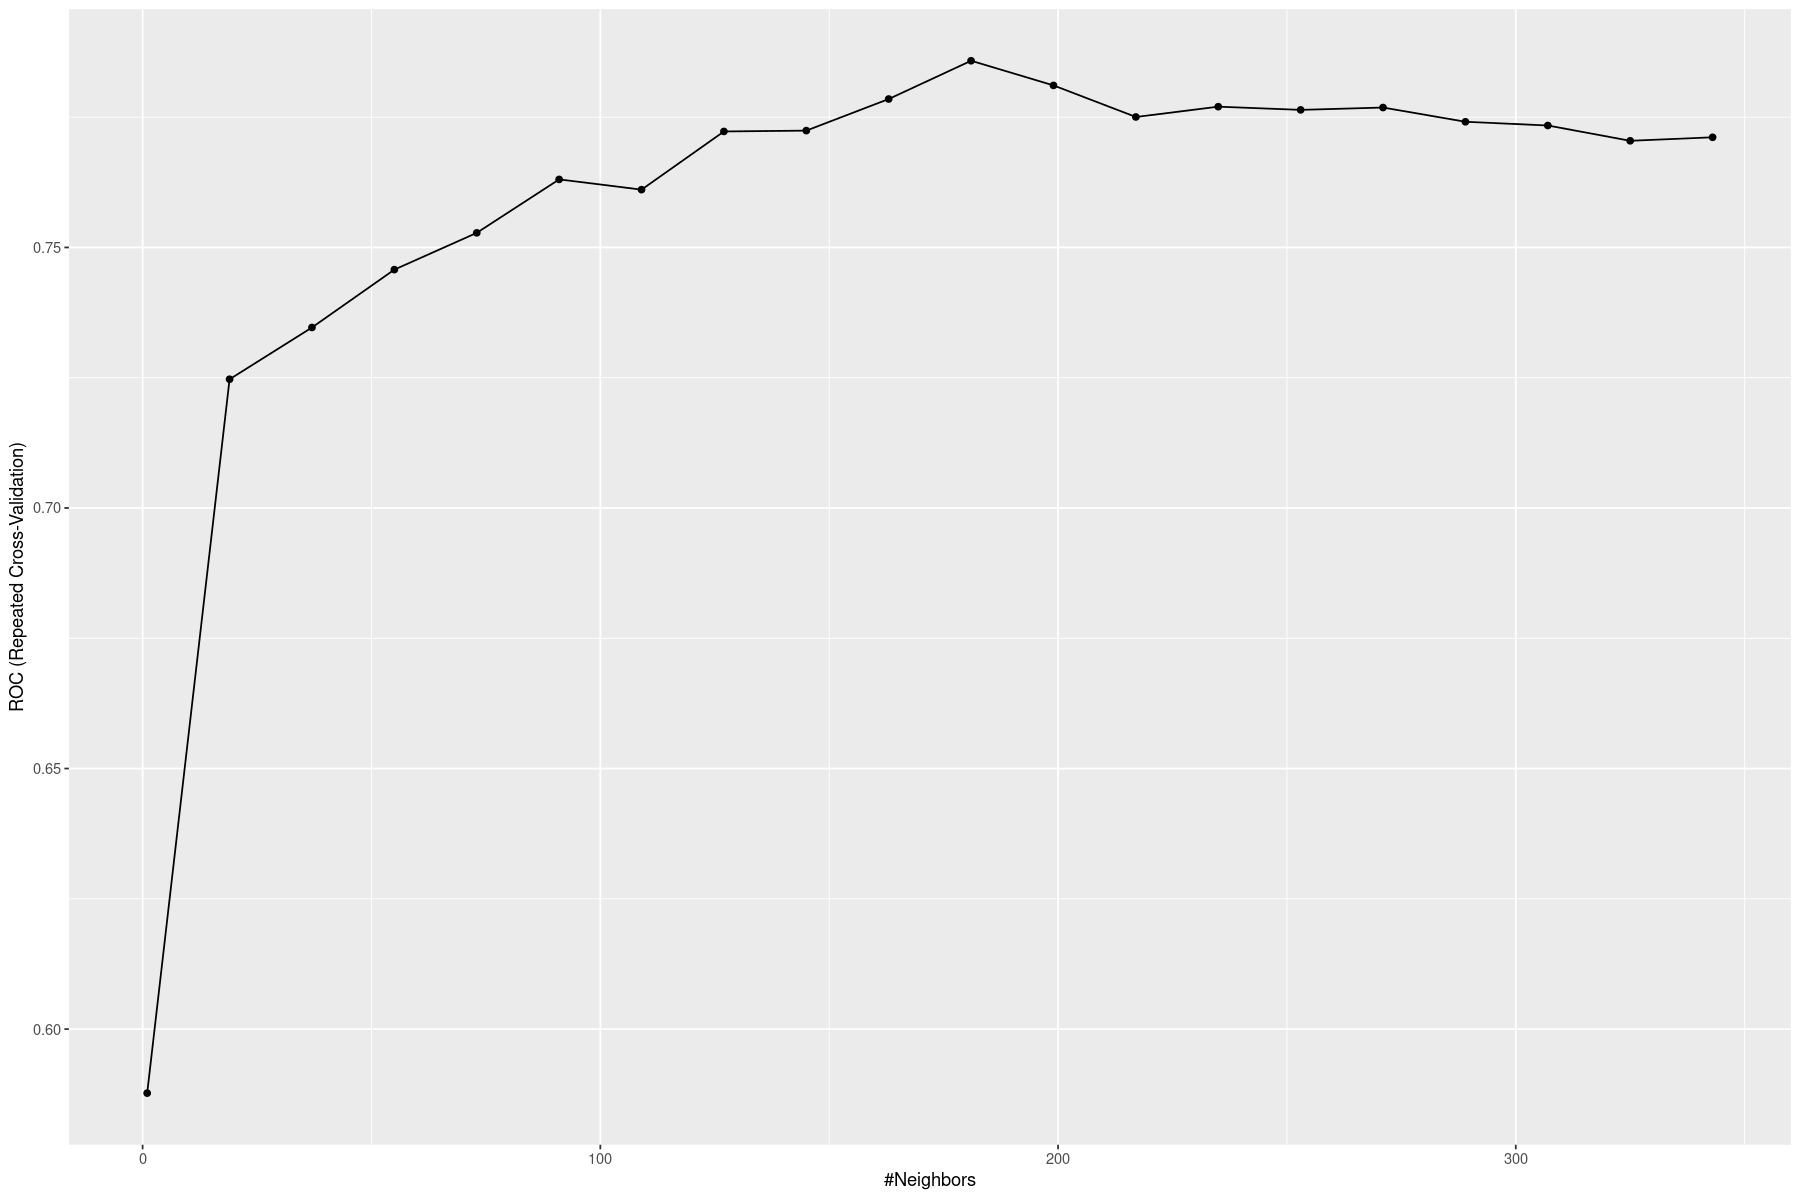

In [37]:
# Create blueprint
blueprint <- recipe(Attrition ~ ., data = attrition_train) %>%
  step_nzv(all_nominal()) %>%
  step_integer(contains("Satisfaction")) %>%
  step_integer(WorkLifeBalance) %>%
  step_integer(JobInvolvement) %>%
  step_dummy(all_nominal(), -all_outcomes(), one_hot = TRUE) %>%
  step_center(all_numeric(), -all_outcomes()) %>%
  step_scale(all_numeric(), -all_outcomes())

# Create a resampling method
cv <- trainControl(
  method = "repeatedcv", 
  number = 10, 
  repeats = 5,
  classProbs = TRUE,                 
  summaryFunction = twoClassSummary
)

# Create a hyperparameter grid search
hyper_grid <- expand.grid(
  k = floor(seq(1, nrow(attrition_train)/3, length.out = 20))
)

# Fit knn model and perform grid search
knn_grid <- train(
  blueprint, 
  data = attrition_train, 
  method = "knn", 
  trControl = cv, 
  tuneGrid = hyper_grid,
  metric = "ROC"
)

ggplot(knn_grid)

In [38]:
knn_grid

k-Nearest Neighbors 

1030 samples
  30 predictor
   2 classes: 'No', 'Yes' 

Recipe steps: nzv, integer, integer, integer, dummy, center, scale 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 927, 927, 927, 928, 926, 927, ... 
Resampling results across tuning parameters:

  k    ROC        Sens       Spec       
    1  0.5877067  0.9136488  0.261764706
   19  0.7247062  0.9997701  0.053308824
   37  0.7346422  1.0000000  0.006029412
   55  0.7457471  1.0000000  0.000000000
   73  0.7528017  1.0000000  0.000000000
   91  0.7630586  1.0000000  0.000000000
  109  0.7610929  1.0000000  0.000000000
  127  0.7722589  1.0000000  0.000000000
  145  0.7724200  1.0000000  0.000000000
  163  0.7784860  1.0000000  0.000000000
  181  0.7858286  1.0000000  0.000000000
  199  0.7810953  1.0000000  0.000000000
  217  0.7750392  1.0000000  0.000000000
  235  0.7770163  1.0000000  0.000000000
  253  0.7764010  1.0000000  0.000000000
  271  0.7768503  1.0000000  0.0000